In [97]:
import numpy as np
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import prophet as pt
import datetime as dt
from sklearn.metrics import mean_squared_error, mean_absolute_error
sns.set_style('whitegrid')
plt.style.use("default")
%matplotlib inline
from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr
yf.pdr_override()
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential, load_model
from sklearn import preprocessing
from sklearn import metrics
import tensorflow as tf
import joblib


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pylab import rcParams
from vnstock import *


df = pd.DataFrame(listing_companies())\
search_word = 'mobile'\
result = df[df['organName'].str.contains(search_word)]\
print(result)

Vin = VIC\
Viettel = VGI\
FPT = FPT\
thế giới di động = MWG\
Petrolimex = PLC

In [99]:
df = pd.DataFrame(listing_companies())
search_word = 'FAHASA'
result = df[df['organName'].str.contains(search_word)]
print(result)



    ticker comGroupCode                                          organName  \
816    FHS        UPCOM  Công ty Cổ phần Phát hành sách Thành phố Hồ Ch...   

                     organShortName organTypeCode comTypeCode  \
816  Phát hành sách TP HCM - FAHASA            DN          CT   

                             icbName  \
816  Sách, ấn bản & sản phẩm văn hóa   

                                           icbNamePath             sector  \
816  Dịch vụ Tiêu dùng/Truyền thông/Truyền thông/Sá...  Dịch vụ Tiêu dùng   

         industry  ... VNCOND VNCONS  VNENE  VNFIN  VNHEAL  VNIND   VNIT  \
816  Truyền thông  ...  False  False  False  False   False  False  False   

     VNMAT  VNREAL  VNUTI  
816  False   False  False  

[1 rows x 35 columns]


In [186]:
company_overview('FPT')
df = stock_historical_data("FPT", "2018-01-01", '2023-10-8', "1D")
df = pd.DataFrame(df)
close = df["close"].tolist()


In [125]:
#foreign companies
start_date = dt.datetime(2016, 10, 1)
end_date = dt.datetime(2021, 9, 30)
df = pdr.get_data_yahoo('GOOG', start_date, end_date)
#df = yf.download('GOOG', start=start_date, end=end_date)
display(df.head())


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-10-03,38.712502,38.803249,38.474998,38.627998,38.627998,25576000
2016-10-04,38.801498,38.935501,38.644501,38.821499,38.821499,24028000
2016-10-05,38.965500,39.103500,38.782501,38.823502,38.823502,29224000
2016-10-06,38.950001,39.023998,38.777000,38.842999,38.842999,21414000
2016-10-07,38.983002,38.983002,38.537498,38.754002,38.754002,18664000


# TURTLE AGENT

In [3]:
count = int(np.ceil(len(df) * 0.1))
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
signals['trend'] = df['Close']
signals['RollingMax'] = (signals.trend.shift(1).rolling(count).max())
signals['RollingMin'] = (signals.trend.shift(1).rolling(count).min())
signals.loc[signals['RollingMax'] < signals.trend, 'signal'] = -1
signals.loc[signals['RollingMin'] > signals.trend, 'signal'] = 1
signals


,signal,trend,RollingMax,RollingMin
Date,,,,
2022-10-03,0.0,142.449997,NaN,NaN
2022-10-04,0.0,146.100006,NaN,NaN
2022-10-05,0.0,146.399994,NaN,NaN
2022-10-06,0.0,145.429993,NaN,NaN
2022-10-07,0.0,140.089996,NaN,NaN
...,...,...,...,...
2023-09-25,0.0,176.080002,189.699997,173.929993
2023-09-26,1.0,171.960007,189.699997,173.929993
2023-09-27,1.0,170.429993,189.699997,171.960007


In [5]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)

    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest


In [6]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['signal'])


day 27: buy 1 units at price 134.869995, total balance 9865.130005
day 53: buy 1 units at price 134.509995, total balance 9730.620010
day 54: buy 1 units at price 132.369995, total balance 9598.250015
day 55: buy 1 units at price 132.300003, total balance 9465.950012
day 57: buy 1 units at price 132.229996, total balance 9333.720016
day 58: buy 1 units at price 131.860001, total balance 9201.860016
day 59: buy 1 units at price 130.029999, total balance 9071.830017
day 60: buy 1 units at price 126.040001, total balance 8945.790016
day 63: buy 1 units at price 125.070000, total balance 8820.720016
day 65: buy 1 units at price 125.019997, total balance 8695.700020
day 77, sell 1 units at price 142.529999, investment 14.005761 %, total balance 8838.230019,
day 79, sell 1 units at price 143.960007, investment 15.149585 %, total balance 8982.190025,
day 80, sell 1 units at price 145.929993, investment 16.725321 %, total balance 9128.120018,
day 84, sell 1 units at price 150.820007, investmen

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8900\704551773.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  state = signal[i]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8900\704551773.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  shares = initial_money // real_movement[i]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8900\704551773.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  initial_money -= buy_units * real_mo

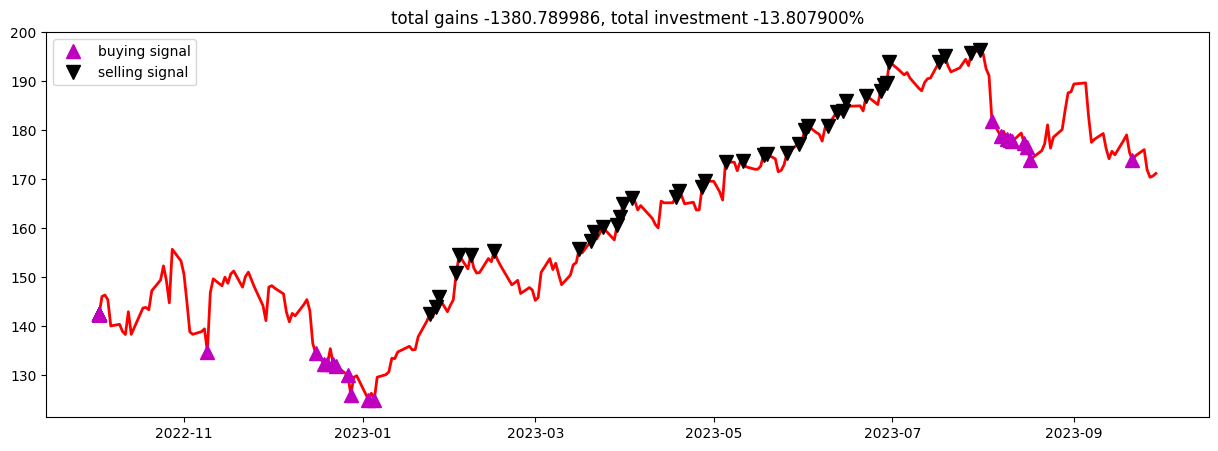

In [7]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()


# LSTM MODEL

In [188]:
df.describe()


,open,high,low,close,volume
count,1439.000000,1439.000000,1439.000000,1439.000000,1.439000e+03
mean,44099.822794,44605.970118,43637.232106,44123.373176,1.655512e+06
std,22777.484582,23044.699983,22517.843046,22787.934911,1.093684e+06
min,16300.000000,16730.000000,16250.000000,16379.000000,1.239000e+05
25%,22290.000000,22600.000000,21985.000000,22190.000000,8.911500e+05
50%,32080.000000,32740.000000,31910.000000,32560.000000,1.373800e+06
75%,66545.000000,67095.000000,65930.000000,66400.000000,2.156650e+06
max,99000.000000,100800.000000,98500.000000,99000.000000,8.399400e+06


In [187]:
df = pd.DataFrame(df)


In [189]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1439 entries, 0 to 1438
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    1439 non-null   object
 1   open    1439 non-null   int32 
 2   high    1439 non-null   int32 
 3   low     1439 non-null   int32 
 4   close   1439 non-null   int32 
 5   volume  1439 non-null   int64 
 6   ticker  1439 non-null   object
dtypes: int32(4), int64(1), object(2)
memory usage: 56.3+ KB


In [190]:
df.reset_index(inplace=True)


In [191]:
df1 = df.drop(['index', 'ticker'], axis = 1)


In [192]:
df.rename(columns={'time':'date'},inplace=True)


In [193]:
df.head()


,index,date,open,high,low,close,volume,ticker
0,0,2018-01-02,20480,21390,20450,21390,5022160,FPT
1,1,2018-01-03,21630,21700,21270,21390,2829930,FPT
2,2,2018-01-04,21450,21810,21420,21810,2784800,FPT
3,3,2018-01-05,21810,21840,21420,21450,2851450,FPT
4,4,2018-01-08,21310,21780,21200,21780,2529030,FPT


In [196]:
df1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1439 entries, 0 to 1438
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    1439 non-null   object
 1   open    1439 non-null   int32 
 2   high    1439 non-null   int32 
 3   low     1439 non-null   int32 
 4   close   1439 non-null   int32 
 5   volume  1439 non-null   int64 
dtypes: int32(4), int64(1), object(1)
memory usage: 45.1+ KB


Check distribution of each features

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11052\332507856.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df, x=df[column], color='#75f8f2')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11052\332507856.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df, x=df[column], color='#75f8f2')


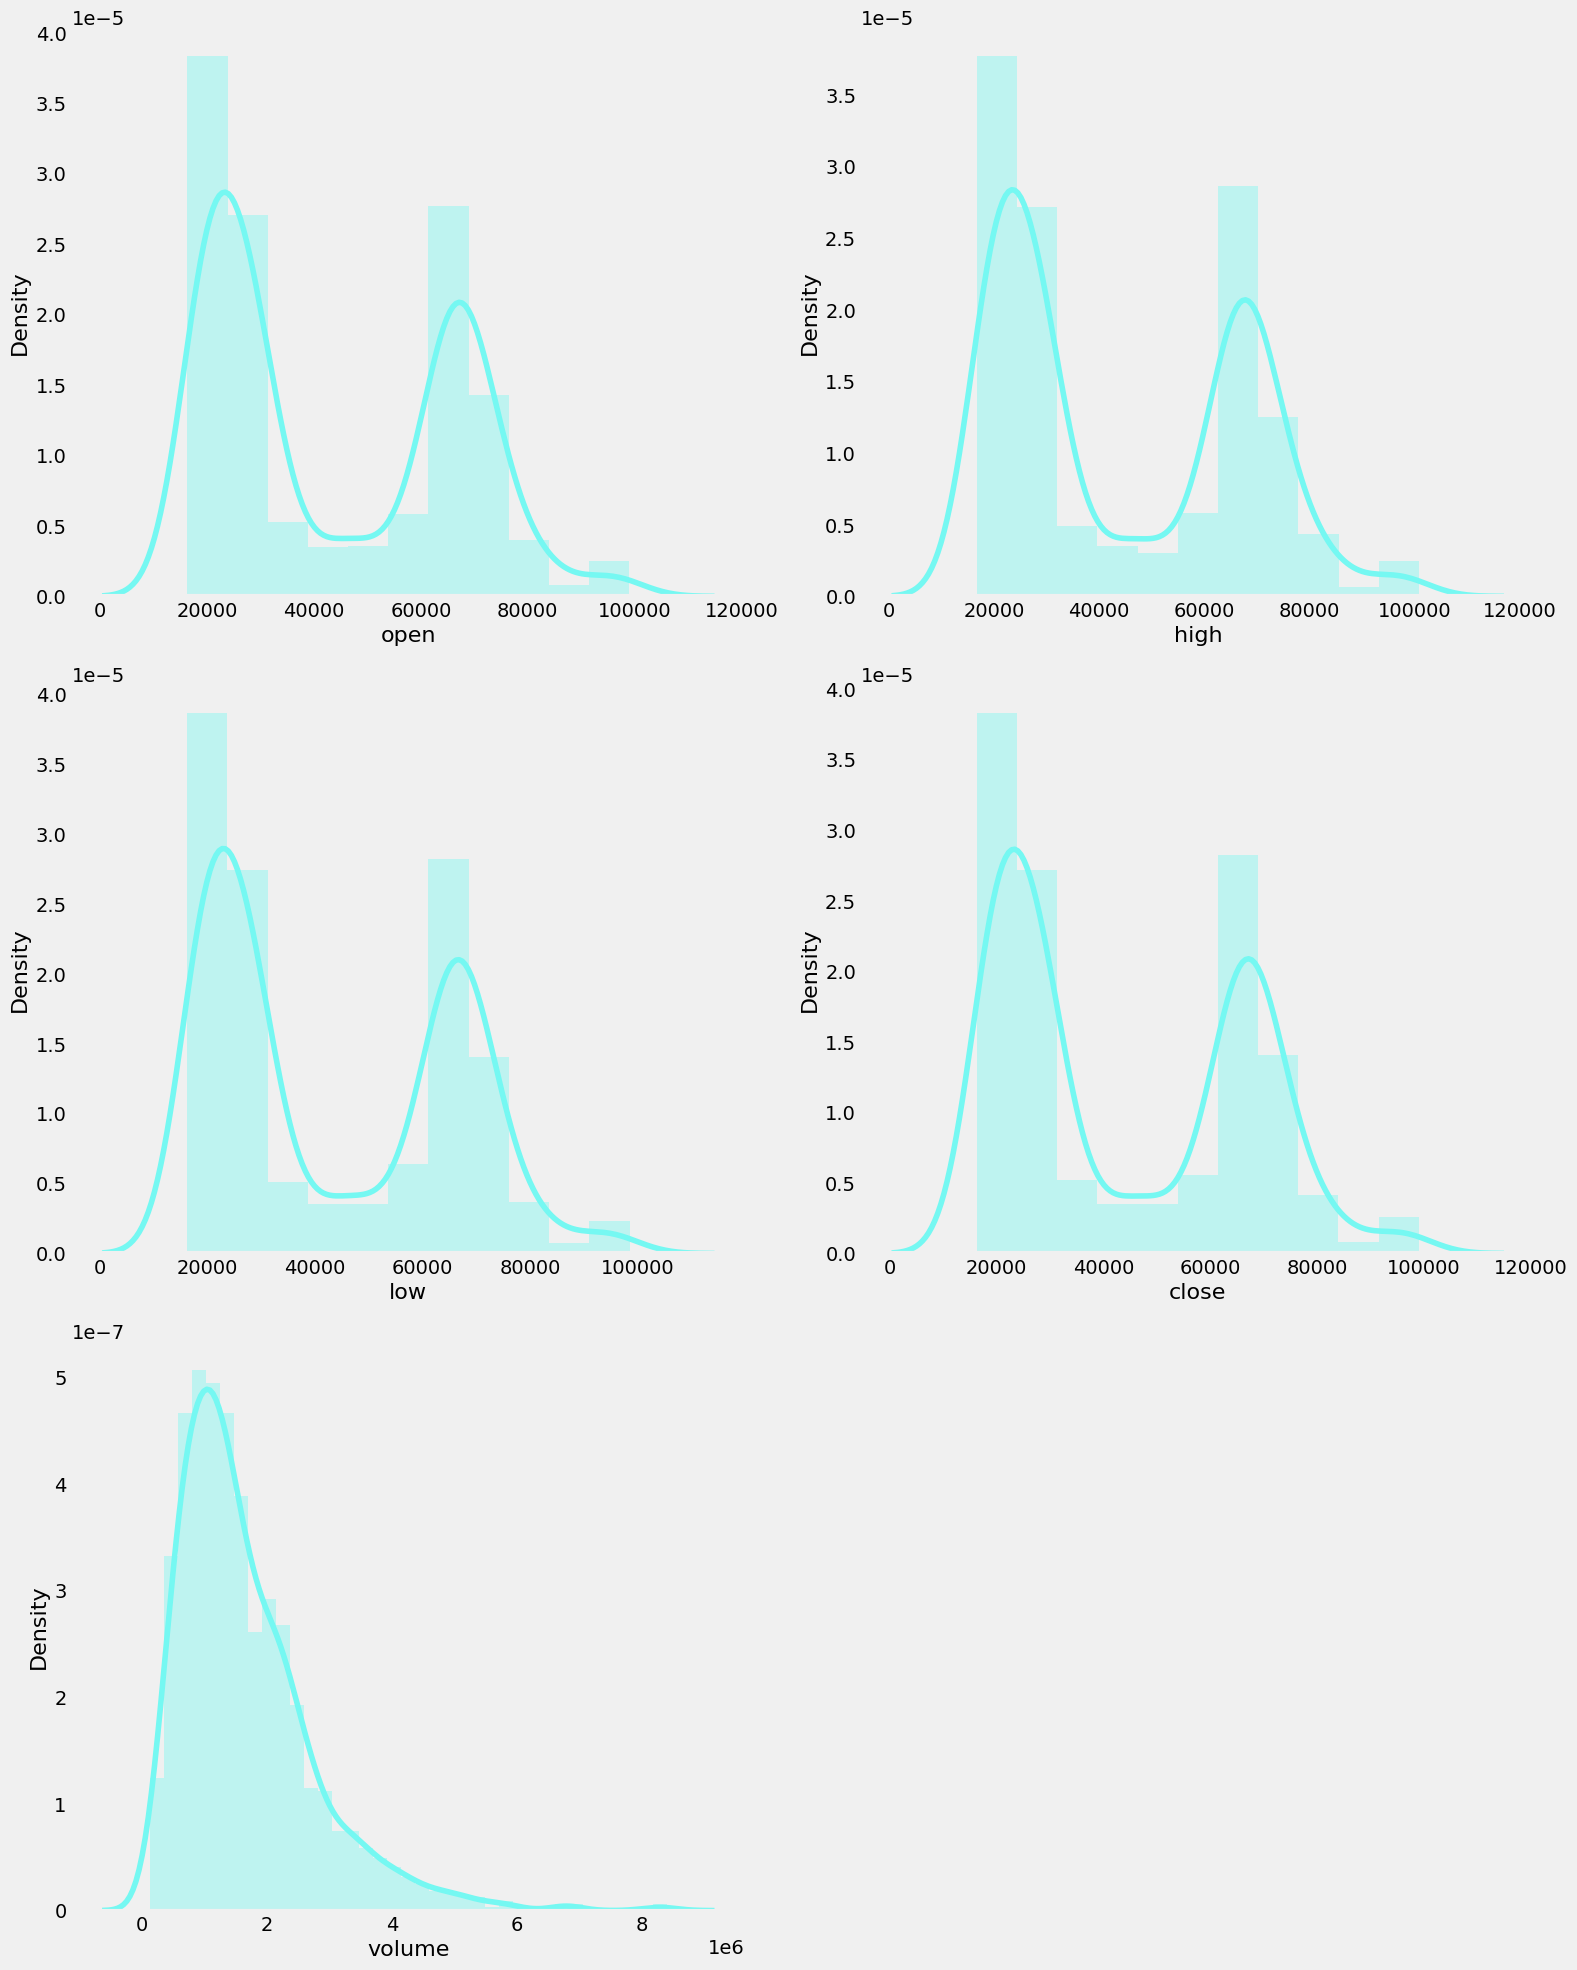

In [197]:
features = ['open', 'high', 'low', 'close', 'volume']
sns.set_palette("PiYG")
plt.figure(figsize=(16,26))
for idx, column in enumerate(features):
    plt.subplot(4, 2, idx + 1)
    sns.distplot(df, x=df[column], color='#75f8f2')
    #plt.title(column, backgroundcolor='black', color='orange', fontsize=25)
    plt.xticks()
    plt.xlabel(column, fontsize=16)
    plt.ylabel('Density', fontsize=16)
    plt.grid()

plt.tight_layout()
plt.show()


checking The Behavior Of Features In Relation To 'close'

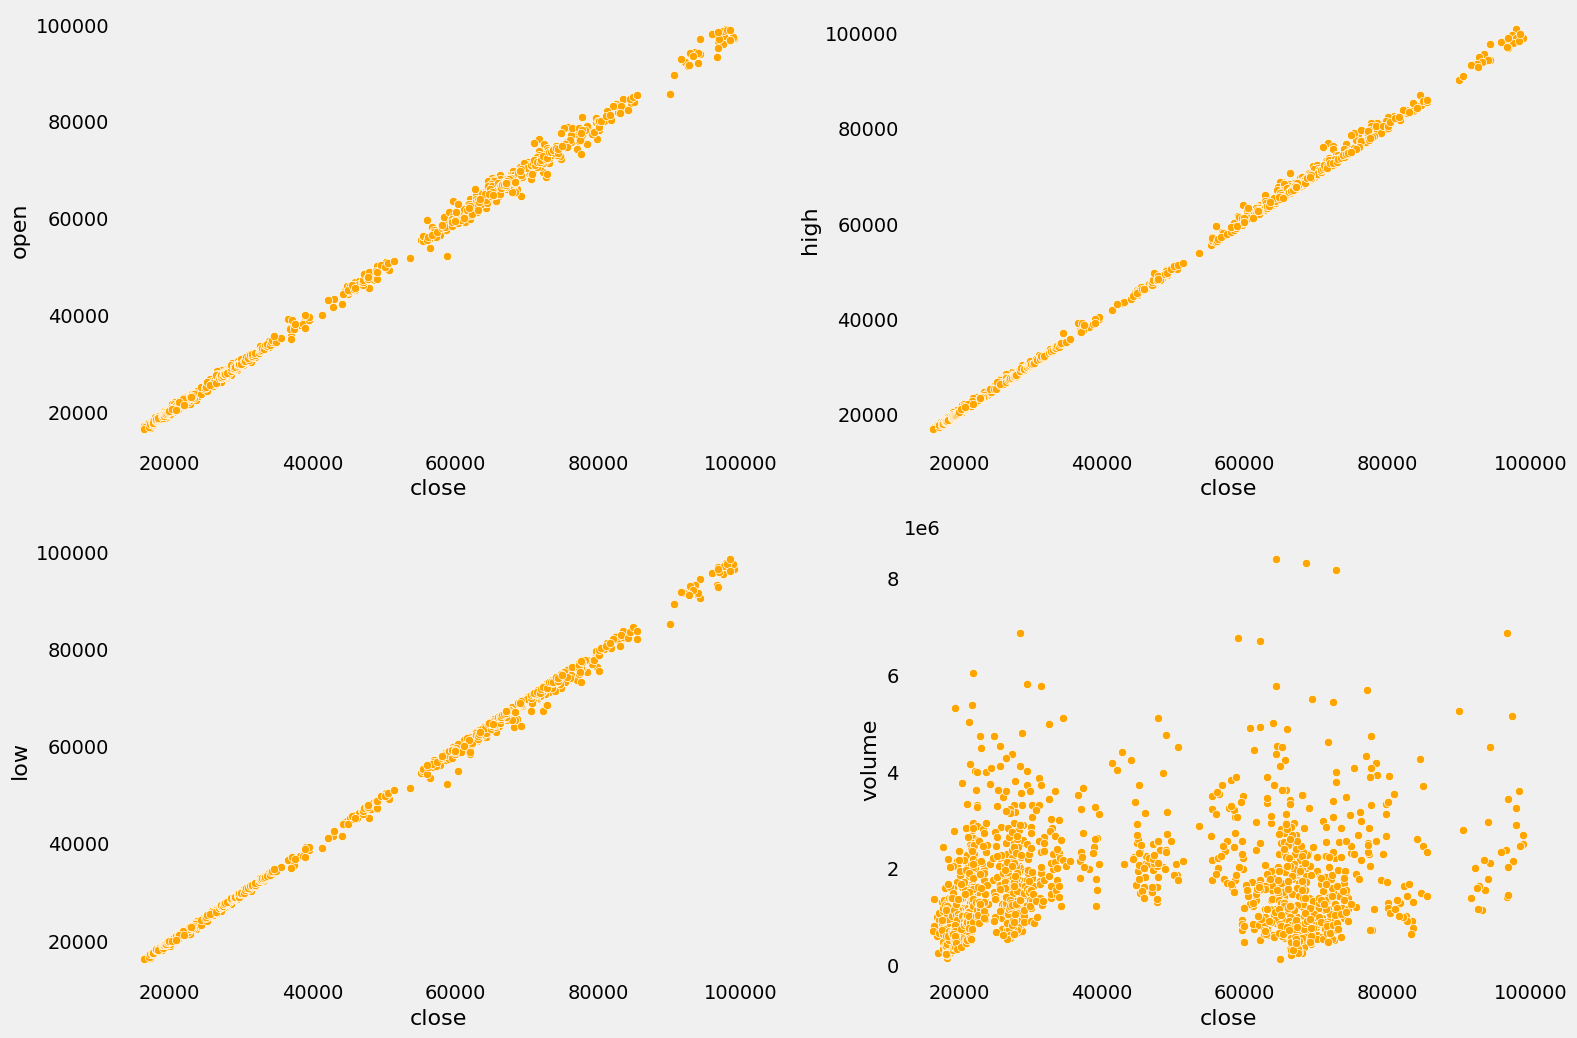

In [198]:
features = ['open', 'high', 'low', 'volume']
sns.set_palette("PiYG")
plt.figure(figsize=(16,26))
for idx, column in enumerate(features):
    plt.subplot(5, 2,  idx + 1)
    sns.scatterplot(x =df['close'], y=df[column] , data = df, color='orange')
    #plt.title(column, backgroundcolor='black', color='#75f8f2', fontsize=25)
    plt.xlabel('close', fontsize=16)
    plt.ylabel(column, fontsize=16)
    plt.grid()
plt.tight_layout()
plt.show()


Boxplot distribution

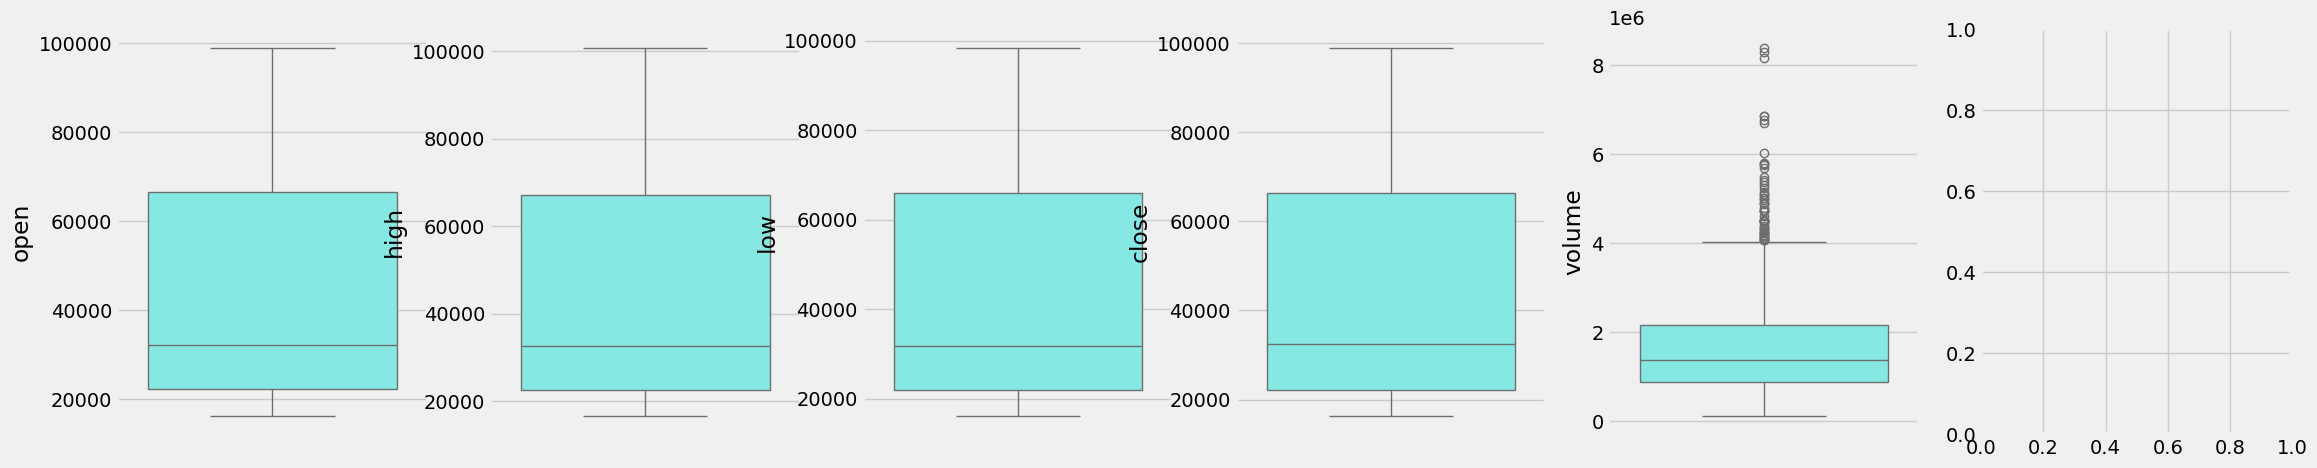

In [199]:
features = ['open', 'high', 'low', 'close', 'volume']
fig  = plt.subplots(nrows = 1, ncols = 6,figsize = (25,5))
for i in range(len(features)) :
    plt.subplot(1, 6,i+1)
    ax = sns.boxplot(df[features[i]], color="#75f8f2")

plt.show()


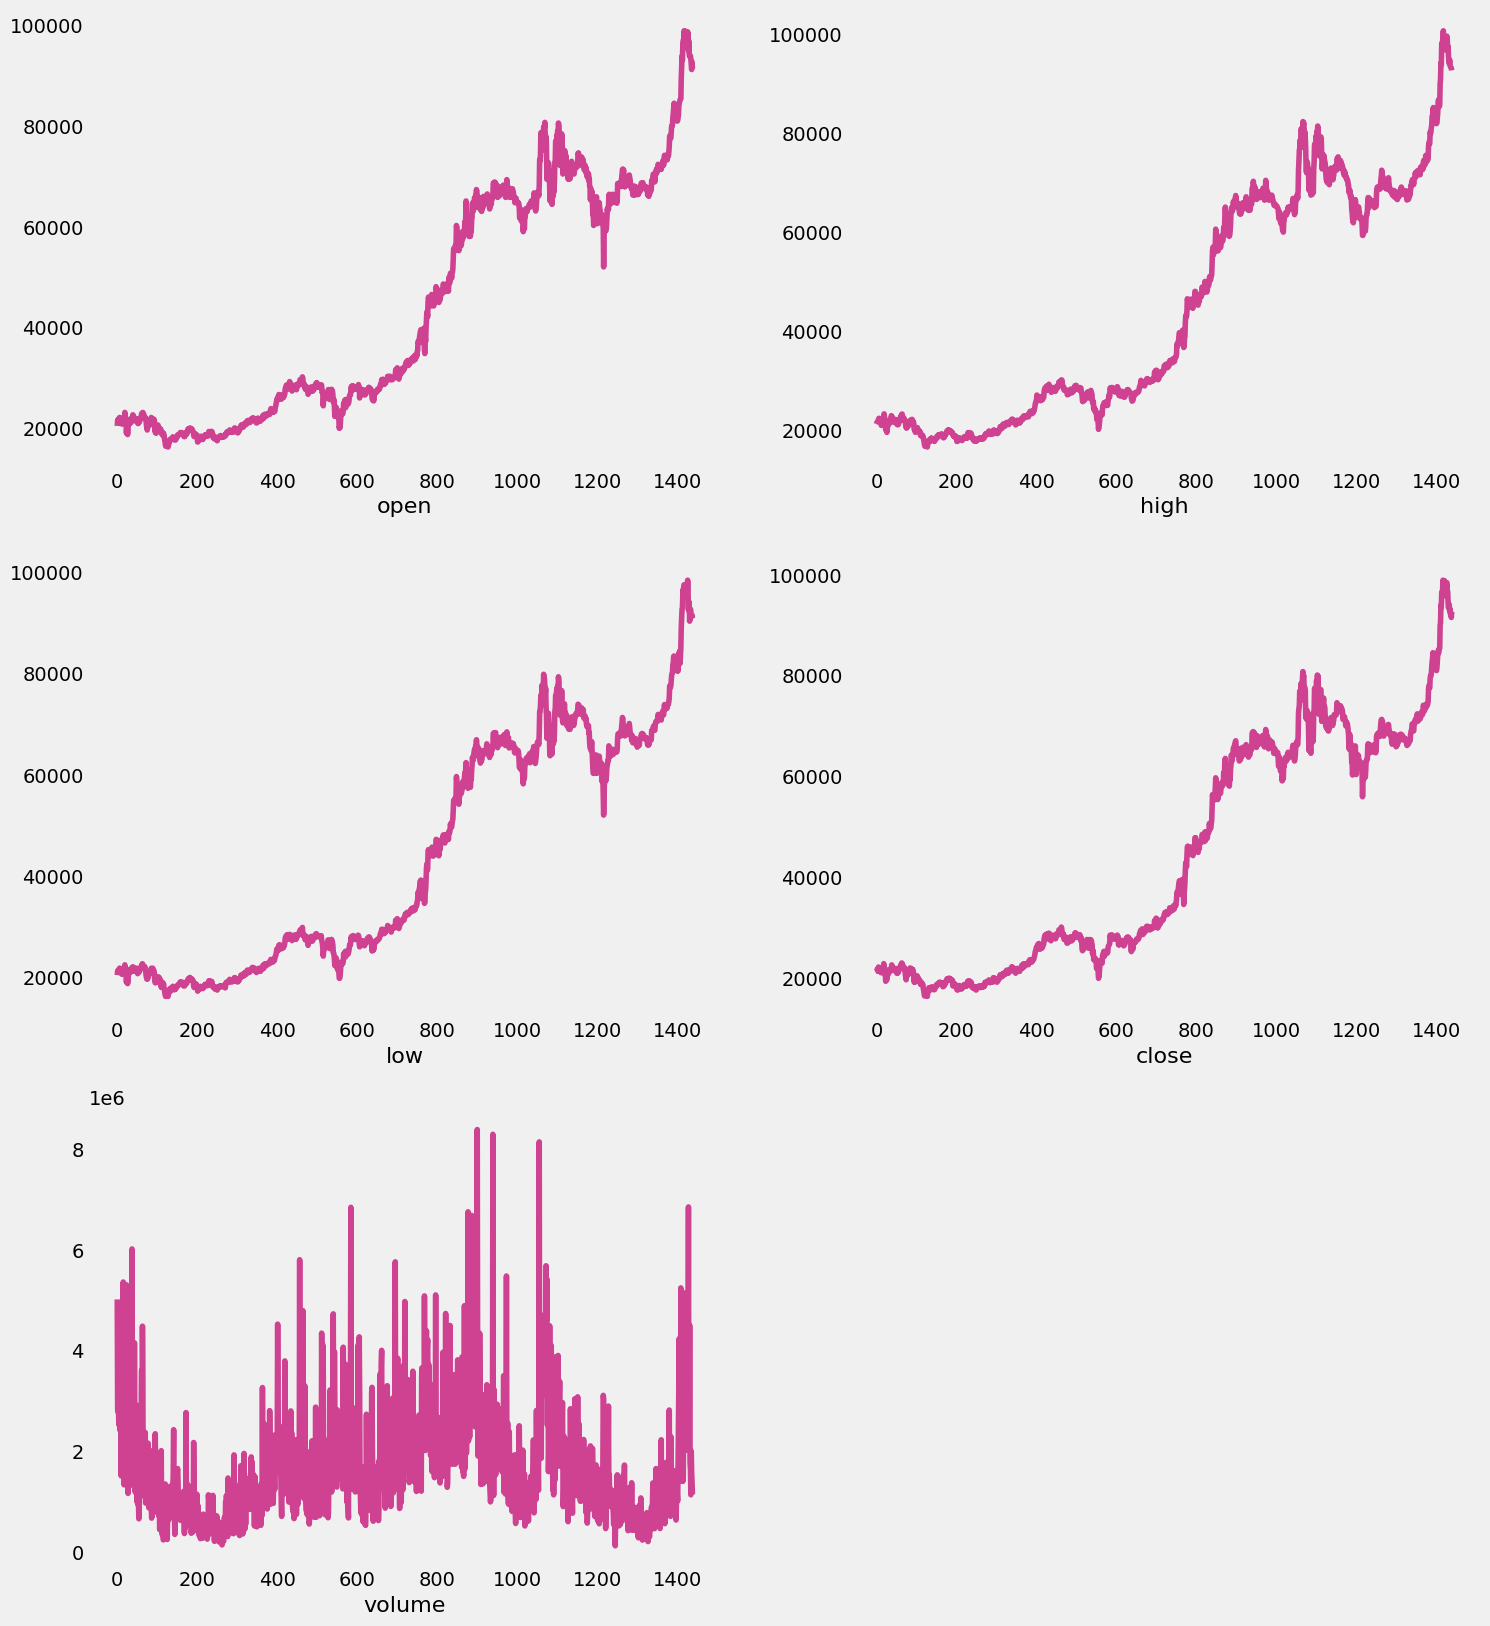

In [200]:
features = ['open', 'high', 'low', 'close', 'volume']
plt.figure(figsize=(16,26))
for idx, column in enumerate(features):
    plt.subplot(4, 2, idx + 1)
    plt.plot(df[column])
    #plt.title(column, backgroundcolor='black', color='orange', fontsize=25)
    plt.xticks()
    plt.xlabel(column, fontsize=16)
    plt.grid()



Moving average:

A moving average (MA), a popular technical indicator, smoothes price movements by removing the noise from erratic short-term price swings. There are numerous ways to build moving averages, and the number of days used for the averaging interval might vary. The average is calculated over a predetermined time frame, such as weeks, days, hours, minutes.

In [201]:
# New Style
plt.style.use("fivethirtyeight")


In [202]:
df1= df.copy()


In [203]:
df1.head()


,index,date,open,high,low,close,volume,ticker
0,0,2018-01-02,20480,21390,20450,21390,5022160,FPT
1,1,2018-01-03,21630,21700,21270,21390,2829930,FPT
2,2,2018-01-04,21450,21810,21420,21810,2784800,FPT
3,3,2018-01-05,21810,21840,21420,21450,2851450,FPT
4,4,2018-01-08,21310,21780,21200,21780,2529030,FPT


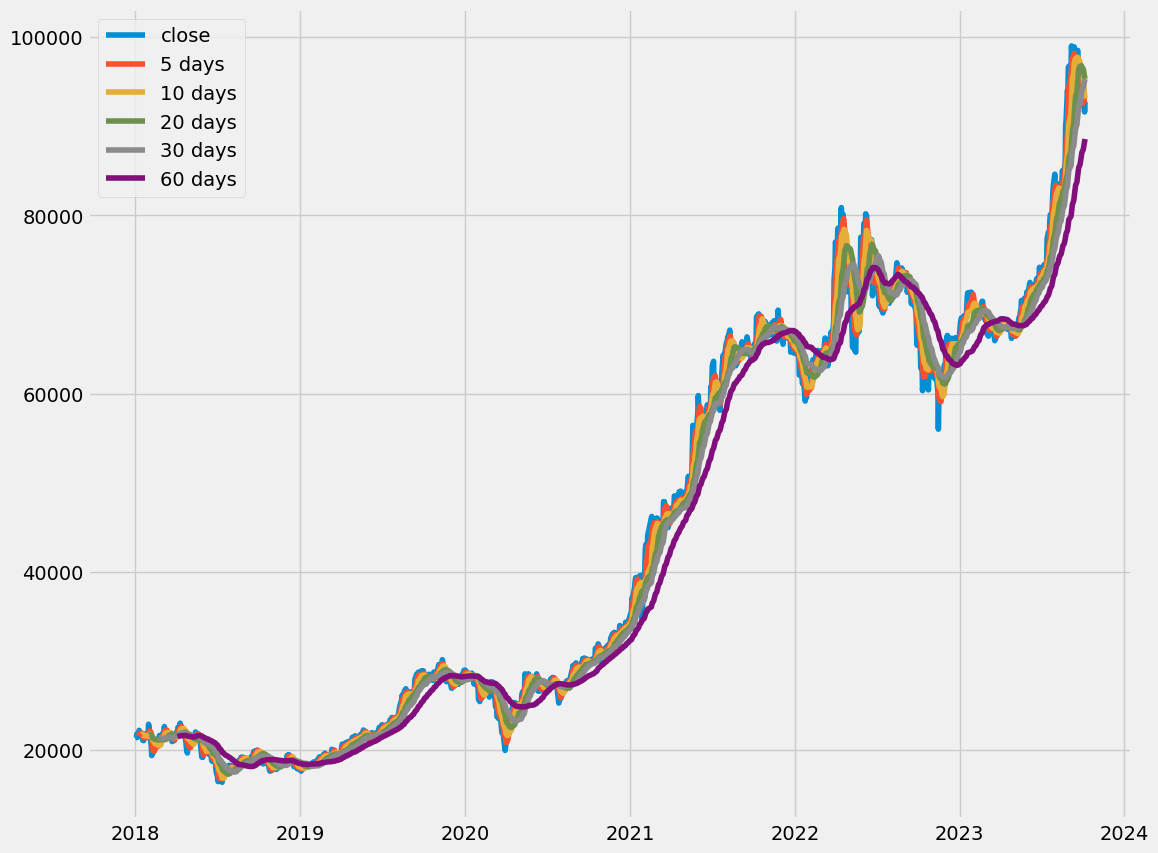

In [204]:
# Checking and choosing the best time step
ma_days = [5, 10, 20, 30, 60]

for MA in ma_days:
    column_name = f"MA in {MA} days"
    df1[column_name] = df1['close'].rolling(MA).mean()

plt.figure(figsize=(12,10))

plt.plot(df1['date'],df1['close'],label='close')
plt.plot(df1['date'],df1['MA in 5 days'],label= '5 days')
plt.plot(df1['date'],df1['MA in 10 days'],label= '10 days')
plt.plot(df1['date'],df1['MA in 20 days'],label= '20 days')
plt.plot(df1['date'],df1['MA in 30 days'],label= '30 days')
plt.plot(df1['date'],df1['MA in 60 days'],label= '60 days')
plt.legend()
plt.show()


Prepering dataset(Train, Test) to using in RNN Models

In [205]:
# Copy from df1
df2= df1.copy()


In [206]:
# Normalaze Data For Create Trin and Test with new dataframe with only the 'Close' column
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
# fit scaler on only one column('close')
scaled = scaler.fit_transform(df2.filter(['close']))
# now have a scaled dataframe with 'colose column'
df3=pd.DataFrame(scaled, columns=['close'])


In [207]:
print(df3.head())
print(df3.describe())


      close
0  0.060650
1  0.060650
2  0.065734
3  0.061377
4  0.065371
             close
count  1439.000000
mean      0.335803
std       0.275813
min       0.000000
25%       0.070333
50%       0.195846
75%       0.605427
max       1.000000


Examining the divisions of Test and Train

In [208]:
# Finding a Length of %90 from the number of rows to Create a train Dataset (using array)
new_dataset_length = int(np.ceil( len(df2.filter(['close']).values) * .9 ))
print('Length of %90 of Dataset is ',new_dataset_length, ' Therefore, the test data length is ',len(df.close) - new_dataset_length)


Length of %90 of Dataset is  1296  Therefore, the test data length is  143


Creating Train and Test from the column of 'close'

In [209]:
# Create the training data set with 20 time steps
# finding the best time step from MA that 20 was the most optimal

train = scaled[0:int(new_dataset_length), :]

time_step = 20

X_train = []
y_train = []

for i in range(time_step, len(train)):
    X_train.append(train[i-time_step:i, 0])
    y_train.append(train[i, 0])
    if i<= (time_step+1):
        print(X_train)
        print(y_train)
        print()


[array([0.06065044, 0.06065044, 0.06573389, 0.06137665, 0.06537079,
       0.07057528, 0.06791252, 0.06791252, 0.06234492, 0.06573389,
       0.06573389, 0.0570194 , 0.0570194 , 0.0566563 , 0.06537079,
       0.066097  , 0.06488665, 0.06270803, 0.07880563, 0.07396425])]
[0.06839665460355115]

[array([0.06065044, 0.06065044, 0.06573389, 0.06137665, 0.06537079,
       0.07057528, 0.06791252, 0.06791252, 0.06234492, 0.06573389,
       0.06573389, 0.0570194 , 0.0570194 , 0.0566563 , 0.06537079,
       0.066097  , 0.06488665, 0.06270803, 0.07880563, 0.07396425]), array([0.06065044, 0.06573389, 0.06137665, 0.06537079, 0.07057528,
       0.06791252, 0.06791252, 0.06234492, 0.06573389, 0.06573389,
       0.0570194 , 0.0570194 , 0.0566563 , 0.06537079, 0.066097  ,
       0.06488665, 0.06270803, 0.07880563, 0.07396425, 0.06839665])]
[0.06839665460355115, 0.06573389332010021]



In [210]:
# Converting the X_train and y_train to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshape the X_train
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# Creating the test dataset
test = scaled[new_dataset_length-time_step:, :]
# Creating DataSets of y_test
y_test =  np.array(scaler.inverse_transform(df3))[new_dataset_length:, :]
# Creating dataset of X_test
X_test = []
for i in range(time_step, len(test)):
    X_test.append(test[i-time_step:i, 0])
# Converting dataset to a numpy array
X_test = np.array(X_test)
y_test = np.array(y_test)
# Reshaping the data for learning in RNN model
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))


Create Models of RNN base on LSTM, GRU, Bidirectional

LSTM

In [211]:
# Creat RNN
RNN1 = tf.keras.models.Sequential()
# The First LSTM Layer
RNN1.add(tf.keras.layers.LSTM(units=130, return_sequences=True, input_shape=(X_train.shape[1],1)))
# The Second LSTM Layer
RNN1.add(tf.keras.layers.LSTM(units=65, return_sequences=False))
# The Connection
RNN1.add(tf.keras.layers.Dense(units=30))
# The Output layer
RNN1.add(tf.keras.layers.Dense(units=1))
# Compiling The RNN
RNN1.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])
# Fitting Model on The Train and Validation Dataset
Model_1 = RNN1.fit(X_train, y_train,validation_data=(X_test, y_test), batch_size=32, epochs=10)


Epoch 1/10
40/40 [==============================] - 23s 60ms/step - loss: 0.0140 - accuracy: 7.8370e-04 - val_loss: 6136216576.0000 - val_accuracy: 0.0000e+00
Epoch 2/10
40/40 [==============================] - 2s 39ms/step - loss: 5.5808e-04 - accuracy: 7.8370e-04 - val_loss: 6136220672.0000 - val_accuracy: 0.0000e+00
Epoch 3/10
40/40 [==============================] - 2s 51ms/step - loss: 4.6167e-04 - accuracy: 7.8370e-04 - val_loss: 6136220672.0000 - val_accuracy: 0.0000e+00
Epoch 4/10
40/40 [==============================] - 2s 47ms/step - loss: 4.7258e-04 - accuracy: 7.8370e-04 - val_loss: 6136220672.0000 - val_accuracy: 0.0000e+00
Epoch 5/10
40/40 [==============================] - 2s 40ms/step - loss: 4.3683e-04 - accuracy: 7.8370e-04 - val_loss: 6136220672.0000 - val_accuracy: 0.0000e+00
Epoch 6/10
40/40 [==============================] - 2s 54ms/step - loss: 5.0977e-04 - accuracy: 7.8370e-04 - val_loss: 6136225280.0000 - val_accuracy: 0.0000e+00
Epoch 7/10
40/40 [=============

In [212]:
# Geting The Model Predicted Price Values
predictions1 = RNN1.predict(X_test)
# Converting scaled number to actual number
predictions1 = scaler.inverse_transform(predictions1)


5/5 [==============================] - 1s 17ms/step


In [213]:
# geting the score and error
print(f'Mean Absolute Error: {metrics.mean_absolute_error(y_test, predictions1)}')
print(f'Mean Squared Error: {metrics.mean_squared_error(y_test, predictions1)}')
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(y_test, predictions1))}')
print(f'R2_Score: {metrics.r2_score(y_test, predictions1)}')


Mean Absolute Error: 1898.824355332168
Mean Squared Error: 5784157.593500311
Root Mean Squared Error: 2405.0275660583
R2_Score: 0.9486357785051758


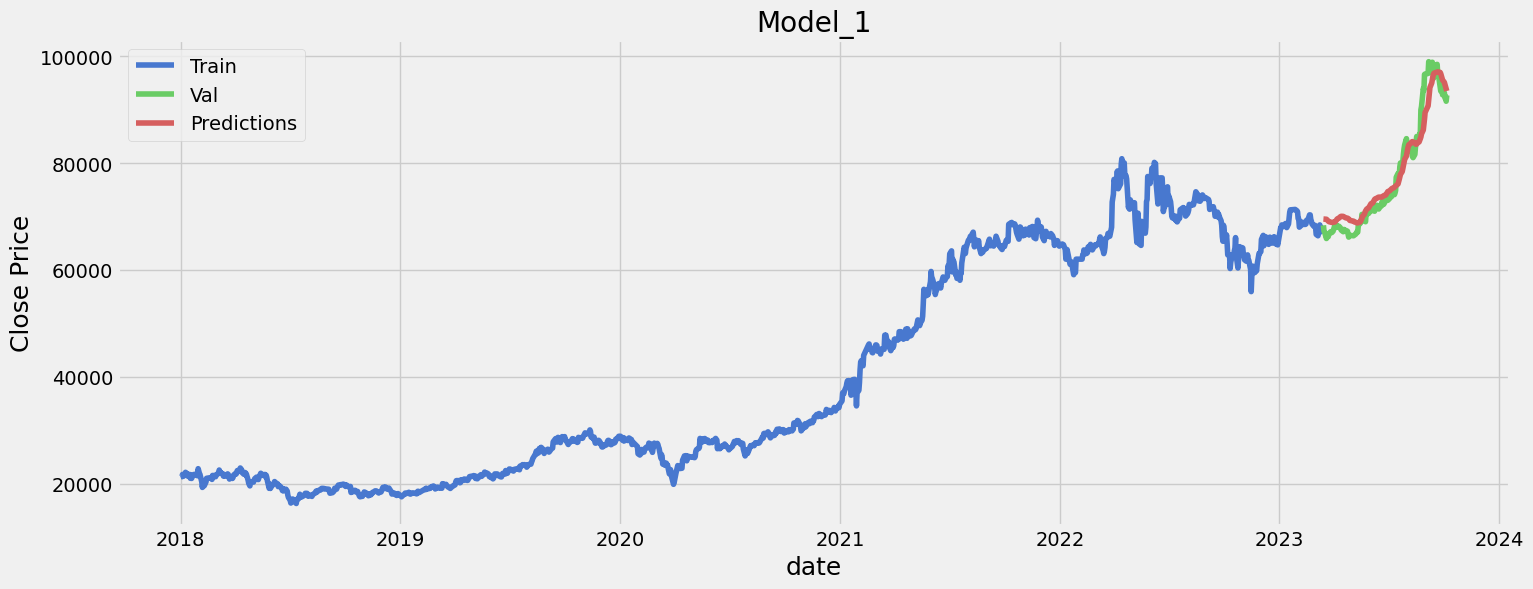

In [214]:
plt.style.use("seaborn-v0_8-muted")
# Create train and val data from DataFrame
train = df2.filter(['close'])[:new_dataset_length]
valid = df2.filter(['close'])[new_dataset_length:]
valid['Predictions1'] = predictions1

# Visualizing the data
plt.figure(figsize=(16,6))
plt.title('Model_1')
plt.xlabel('date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(df1['date'].iloc[:new_dataset_length],train['close'])
plt.plot(df1['date'].iloc[new_dataset_length:],valid[['close', 'Predictions1']])
plt.legend(['Train', 'Val', 'Predictions'], loc='best')
plt.show()


GRU

In [215]:
# Creat RNN
RNN2 = tf.keras.models.Sequential()
# The First GRU Layer
RNN2.add(tf.keras.layers.GRU(units=130, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
# The Second GRU Layer
RNN2.add(tf.keras.layers.GRU(units=65, return_sequences=False, activation='tanh'))
# The Connection
RNN2.add(tf.keras.layers.Dense(units=30))
# The Output layer
RNN2.add(tf.keras.layers.Dense(units=1))
# Compiling The RNN
RNN2.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])
# Fitting Model on The Train and Validation Dataset
Model_2 = RNN2.fit(X_train, y_train,validation_data=(X_test, y_test), batch_size=32, epochs=10)


Epoch 1/10
40/40 [==============================] - 8s 62ms/step - loss: 0.0064 - accuracy: 7.8370e-04 - val_loss: 6136220672.0000 - val_accuracy: 0.0000e+00
Epoch 2/10
40/40 [==============================] - 1s 37ms/step - loss: 3.0867e-04 - accuracy: 7.8370e-04 - val_loss: 6136217088.0000 - val_accuracy: 0.0000e+00
Epoch 3/10
40/40 [==============================] - 2s 44ms/step - loss: 2.0569e-04 - accuracy: 7.8370e-04 - val_loss: 6136220160.0000 - val_accuracy: 0.0000e+00
Epoch 4/10
40/40 [==============================] - 1s 37ms/step - loss: 2.1302e-04 - accuracy: 7.8370e-04 - val_loss: 6136218624.0000 - val_accuracy: 0.0000e+00
Epoch 5/10
40/40 [==============================] - 1s 30ms/step - loss: 1.8768e-04 - accuracy: 7.8370e-04 - val_loss: 6136218112.0000 - val_accuracy: 0.0000e+00
Epoch 6/10
40/40 [==============================] - 1s 38ms/step - loss: 1.9822e-04 - accuracy: 7.8370e-04 - val_loss: 6136216576.0000 - val_accuracy: 0.0000e+00
Epoch 7/10
40/40 [==============

In [216]:
# Geting The Model Predicted Price Values
predictions2 = RNN2.predict(X_test)
# Converting scaled number to actual number
predictions2 = scaler.inverse_transform(predictions2)


5/5 [==============================] - 1s 12ms/step


In [217]:
# geting the score and error
print(f'Mean Absolute Error: {metrics.mean_absolute_error(y_test, predictions2)}')
print(f'Mean Squared Error: {metrics.mean_squared_error(y_test, predictions2)}')
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(y_test, predictions2))}')
print(f'R2_Score: {metrics.r2_score(y_test, predictions2)}')


Mean Absolute Error: 1021.1536822552448
Mean Squared Error: 2093523.0416853053
Root Mean Squared Error: 1446.9011858745937
R2_Score: 0.981409188895808


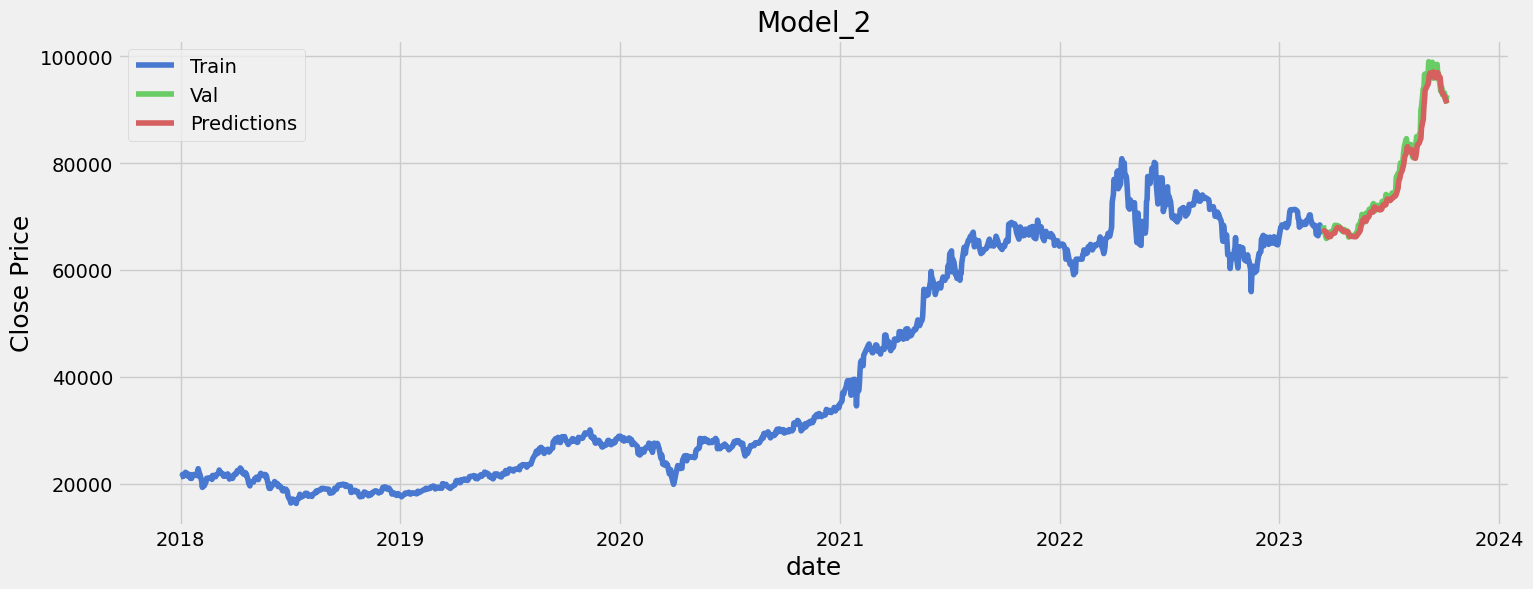

In [218]:
plt.style.use("seaborn-v0_8-muted")
# Create train and val data from DataFrame
train = df2.filter(['close'])[:new_dataset_length]
valid = df2.filter(['close'])[new_dataset_length:]
valid['Predictions2'] = predictions2

# Visualizing the data
plt.figure(figsize=(16,6))
plt.title('Model_2')
plt.xlabel('date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(df1['date'].iloc[:new_dataset_length],train['close'])
plt.plot(df1['date'].iloc[new_dataset_length:],valid[['close', 'Predictions2']])
plt.legend(['Train', 'Val', 'Predictions'], loc='best')
plt.show()


LSTM & Bidirectional

In [178]:
RNN3 = tf.keras.models.Sequential()
# The First Bidirectional & LSTM  Layer
RNN3.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=130, return_sequences=True, input_shape=(X_train.shape[1],1))))
# The Second Bidirectional & LSTM Layer
RNN3.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=65, return_sequences=False)))
# The Connection
RNN3.add(tf.keras.layers.Dense(units=30))
# The Output layer
RNN3.add(tf.keras.layers.Dense(units=1))
# Compiling The RNN
RNN3.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])
# Fitting Model on The Train and Validation Dataset
Model_3 = RNN2.fit(X_train, y_train,validation_data=(X_test, y_test), batch_size=32, epochs=10)


Epoch 1/10
40/40 [==============================] - 2s 40ms/step - loss: 5.4048e-04 - accuracy: 7.8370e-04 - val_loss: 3008913664.0000 - val_accuracy: 0.0000e+00
Epoch 2/10
40/40 [==============================] - 1s 28ms/step - loss: 4.9832e-04 - accuracy: 7.8370e-04 - val_loss: 3008913664.0000 - val_accuracy: 0.0000e+00
Epoch 3/10
40/40 [==============================] - 1s 26ms/step - loss: 4.8019e-04 - accuracy: 7.8370e-04 - val_loss: 3008913152.0000 - val_accuracy: 0.0000e+00
Epoch 4/10
40/40 [==============================] - 1s 34ms/step - loss: 4.6583e-04 - accuracy: 7.8370e-04 - val_loss: 3008913152.0000 - val_accuracy: 0.0000e+00
Epoch 5/10
40/40 [==============================] - 1s 34ms/step - loss: 4.5805e-04 - accuracy: 7.8370e-04 - val_loss: 3008913152.0000 - val_accuracy: 0.0000e+00
Epoch 6/10
40/40 [==============================] - 1s 29ms/step - loss: 5.0577e-04 - accuracy: 7.8370e-04 - val_loss: 3008913152.0000 - val_accuracy: 0.0000e+00
Epoch 7/10
40/40 [==========

In [179]:
# Geting The Models Predicted Price Values
predictions3 = RNN3.predict(X_test)
# Converting scaled number to actual number
predictions3 = scaler.inverse_transform(predictions3)


5/5 [==============================] - 5s 15ms/step


In [180]:
# geting the score and error
print(f'Mean Absolute Error: {metrics.mean_absolute_error(y_test, predictions3)}')
print(f'Mean Squared Error: {metrics.mean_squared_error(y_test, predictions3)}')
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(y_test, predictions3))}')
print(f'R2_Score: {metrics.r2_score(y_test, predictions3)}')


Mean Absolute Error: 10405.088450611887
Mean Squared Error: 145755678.45963934
Root Mean Squared Error: 12072.931643127917
R2_Score: -3.2361487306907337


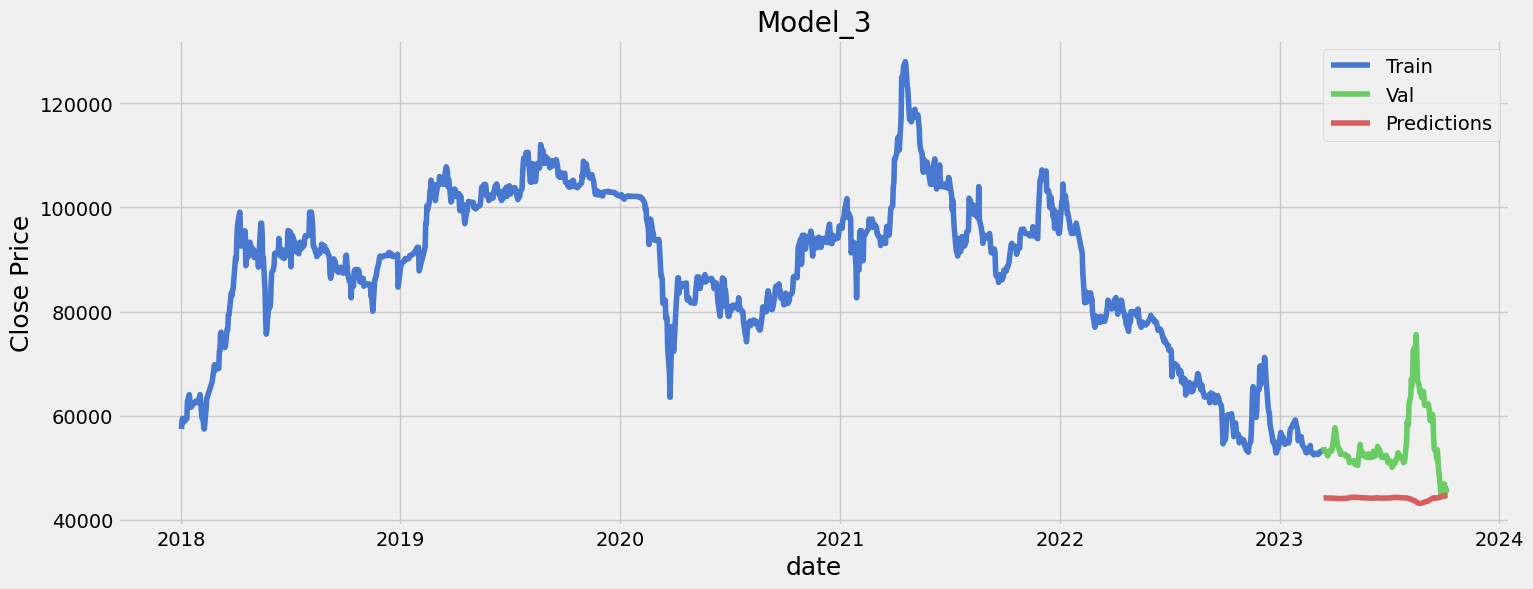

In [181]:
# Create train and val data from DataFrame
train = df2.filter(['close'])[:new_dataset_length]
valid = df2.filter(['close'])[new_dataset_length:]
valid['Predictions3'] = predictions3

# Visualizing the data
plt.figure(figsize=(16,6))
plt.title('Model_3')
plt.xlabel('date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(df1['date'].iloc[:new_dataset_length],train['close'])
plt.plot(df1['date'].iloc[new_dataset_length:],valid[['close', 'Predictions3']])
plt.legend(['Train', 'Val', 'Predictions'], loc='best')
plt.show()


LSTM & GRU

In [219]:
# Creat RNN
RNN4 = tf.keras.models.Sequential()
# The First Layer of LSTM
RNN4.add(tf.keras.layers.LSTM(units=130, return_sequences=True, input_shape=(X_train.shape[1],1)))
# The Second Layer of GRU
RNN4.add(tf.keras.layers.GRU(units=65, return_sequences=False, activation='tanh'))
# The Connection
RNN4.add(tf.keras.layers.Dense(units=30))
# The Output layer
RNN4.add(tf.keras.layers.Dense(units=1))
# Compiling The RNN
RNN4.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])
# Fitting Model on The Train and Validation Dataset
Model_4 = RNN4.fit(X_train, y_train,validation_data=(X_test, y_test), batch_size=32, epochs=10)


Epoch 1/10
40/40 [==============================] - 7s 49ms/step - loss: 0.0147 - accuracy: 7.8370e-04 - val_loss: 6136209408.0000 - val_accuracy: 0.0000e+00
Epoch 2/10
40/40 [==============================] - 1s 31ms/step - loss: 5.5826e-04 - accuracy: 7.8370e-04 - val_loss: 6136221184.0000 - val_accuracy: 0.0000e+00
Epoch 3/10
40/40 [==============================] - 1s 29ms/step - loss: 3.5810e-04 - accuracy: 7.8370e-04 - val_loss: 6136221696.0000 - val_accuracy: 0.0000e+00
Epoch 4/10
40/40 [==============================] - 1s 35ms/step - loss: 3.5280e-04 - accuracy: 7.8370e-04 - val_loss: 6136218112.0000 - val_accuracy: 0.0000e+00
Epoch 5/10
40/40 [==============================] - 2s 39ms/step - loss: 3.4531e-04 - accuracy: 7.8370e-04 - val_loss: 6136218112.0000 - val_accuracy: 0.0000e+00
Epoch 6/10
40/40 [==============================] - 1s 26ms/step - loss: 3.2838e-04 - accuracy: 7.8370e-04 - val_loss: 6136219648.0000 - val_accuracy: 0.0000e+00
Epoch 7/10
40/40 [==============

In [220]:
# Geting The Models Predicted Price Values
predictions4 = RNN4.predict(X_test)
# Converting scaled number to actual number
predictions4 = scaler.inverse_transform(predictions4)


5/5 [==============================] - 1s 13ms/step


In [221]:
# geting the score and error
print(f'Mean Absolute Error: {metrics.mean_absolute_error(y_test, predictions4)}')
print(f'Mean Squared Error: {metrics.mean_squared_error(y_test, predictions4)}')
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(y_test, predictions4))}')
print(f'R2_Score: {metrics.r2_score(y_test, predictions4)}')


Mean Absolute Error: 1537.4541630244755
Mean Squared Error: 5296046.216142561
Root Mean Squared Error: 2301.3140194555285
R2_Score: 0.9529702836592054


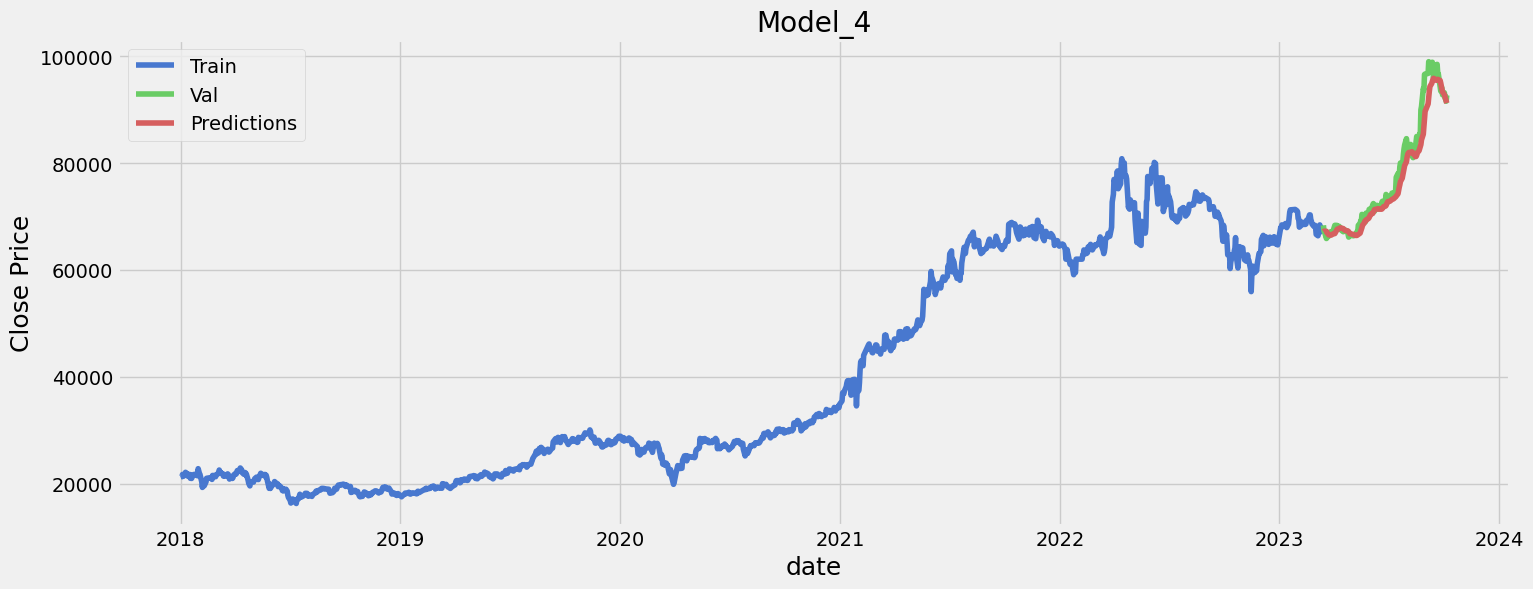

In [222]:
# Create train and val data from DataFrame
train = df2.filter(['close'])[:new_dataset_length]
valid = df2.filter(['close'])[new_dataset_length:]
valid['Predictions4'] = predictions4

# Visualizing the data
plt.figure(figsize=(16,6))
plt.title('Model_4')
plt.xlabel('date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(df1['date'].iloc[:new_dataset_length],train['close'])
plt.plot(df1['date'].iloc[new_dataset_length:],valid[['close', 'Predictions4']])
plt.legend(['Train', 'Val', 'Predictions'], loc='best')
plt.show()


ARIMA

In [95]:
model_autoARIMA = auto_arima([X_train, y_train], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 1112) + inhomogeneous part.

# ARIMA MODEL

Time series analysis

In [12]:
df.drop(['High','Low','Volume','Close','Adj Close'], axis=1, inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2022-10-03 to 2023-09-29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    250 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB


Text(0.5, 1.0, 'Trend of the Time Series')

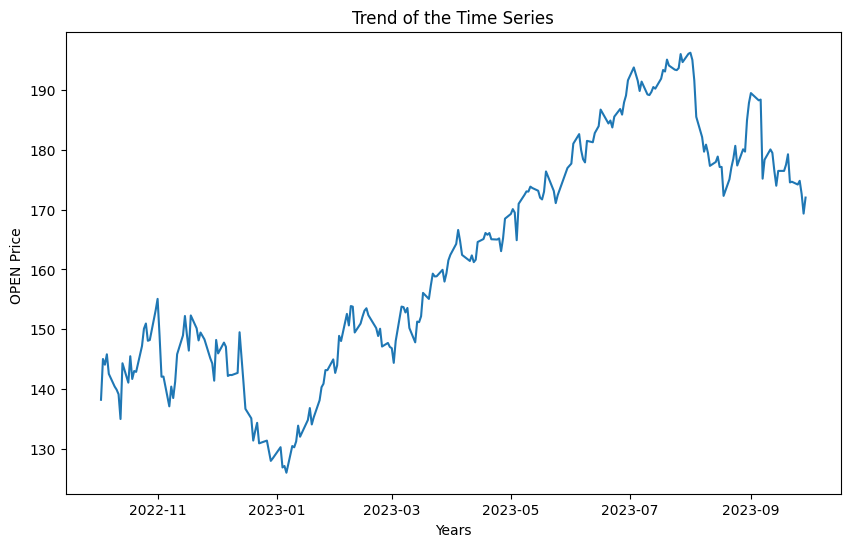

In [13]:
plt.figure(figsize= (10,6))
plt.plot(df)
plt.xlabel('Years')
plt.ylabel('OPEN Price ')
plt.title('Trend of the Time Series')


<Axes: title={'center': 'Seasonality of the Time Series'}, xlabel='month', ylabel='Open'>

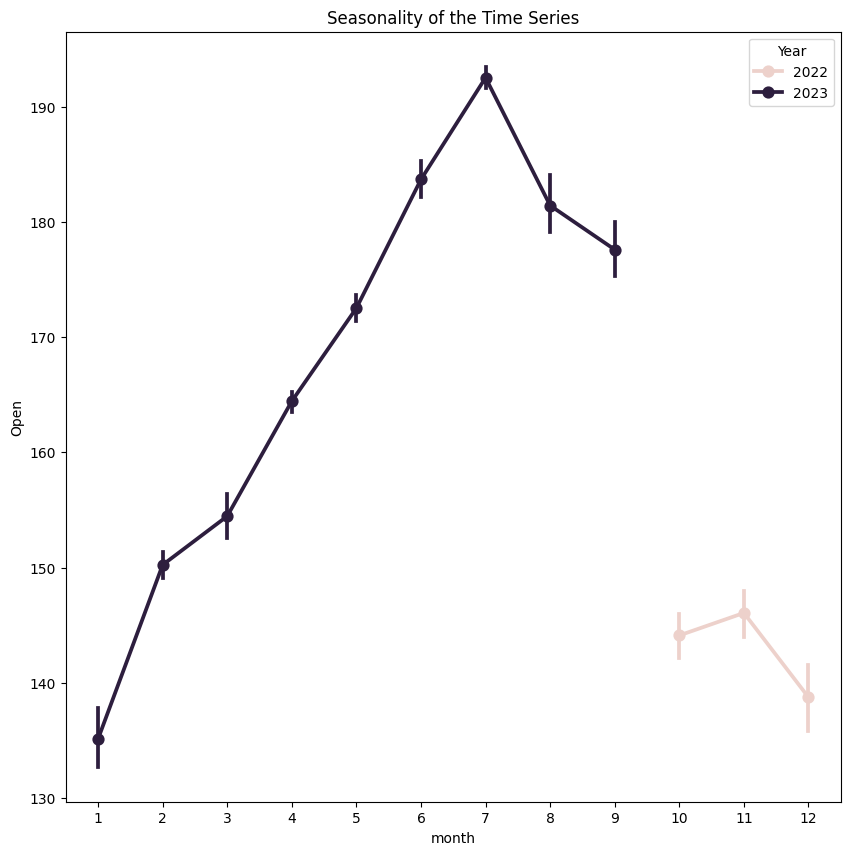

In [14]:
# To plot the seasonality we are going to create a temp dataframe and add columns for Month and Year values
df_temp = df.copy()
df_temp['Year'] = pd.DatetimeIndex(df_temp.index).year
df_temp['month'] = pd.DatetimeIndex(df_temp.index).month
# Stacked line plot
plt.figure(figsize=(10,10))
plt.title('Seasonality of the Time Series')
sns.pointplot(x='month',y='Open',hue='Year',data=df_temp)


In [15]:
print('Results of Dickey-Fuller Test')
df_test = adfuller(df)
df_output = pd.Series(df_test[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in df_test[4].items():
        df_output['Critical Value (%s)' %key] = value
print(df_output)


Results of Dickey-Fuller Test
Test Statistic                  -1.383595
p-value                          0.590115
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64
